# Steam Data
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the weather.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
STEAM_FILE='steam.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats  # mode

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [4]:
stm_df = read_zip_to_panda(ZIP_PATH,STEAM_FILE)
stm_df = fix_date_type(stm_df)
print(stm_df.info()) # only 371 columns (buildings) in this data. Includes Peacock but not Gator. 



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 370 entries, Peacock_lodging_Terrie to Cockatoo_public_Shad
dtypes: float64(370)
memory usage: 49.7 MB
None


In [5]:
cols=stm_df.columns
all_sites=[s.split('_')[0] for s in cols]  # Site is first part of building name like Hog_parking_Linda
uniq_sites = [x for x in set(all_sites)]
site_counts = [[x,all_sites.count(x)] for x in set(all_sites)]
print("Note we only have a few sites!")
print("Buildings per site:\n",site_counts)

Note we only have a few sites!
Buildings per site:
 [['Moose', 12], ['Peacock', 34], ['Eagle', 45], ['Hog', 97], ['Cockatoo', 92], ['Bull', 90]]


## Plot usage per site
Look for completeness and variability.

In [6]:
# Plot temperature time series for one column (building). 
show_all_plots = False
if show_all_plots:
    cols=stm_df.columns
    uniq_sites = [x for x in set(all_sites)]
    for site in uniq_sites:
        for bldg in cols:
            if bldg.startswith(site):
                temp_df = stm_df[bldg]
                temp_df.plot(figsize=(20,5))
        plt.title("Steam for site "+site)
        plt.show()

## Drill down
Only three sites have any buildings with count_nan==0 and count_zero<=50.

Hog has 50 such buildings, but 3 look problematic: 
Hog_education_Robert suddenly dropped by 10 logs as if converting to a new system;
Hog_education_Jared and Hog_education_Mathilda have long flat lines as if values were estimated for some months.

Eagle has 14 such buildings, but 1 might be a problem:
Eagle_education_Wesley is on a different (smaller) scale than all the others.
(Note Eagle_education_Sherrill gets filtered out but it could be left in. It has a precipitous drop and a few missing values.)

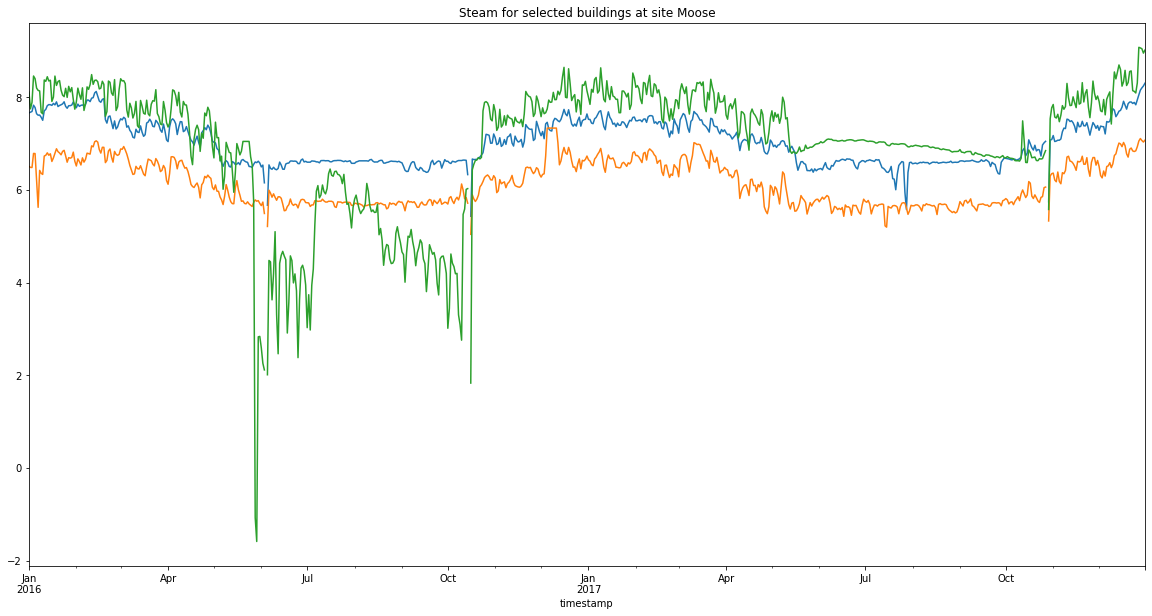

Site Moose has good steam data from 3 buildings:
 ['Moose_education_Diane', 'Moose_education_Marina', 'Moose_education_Abbie']


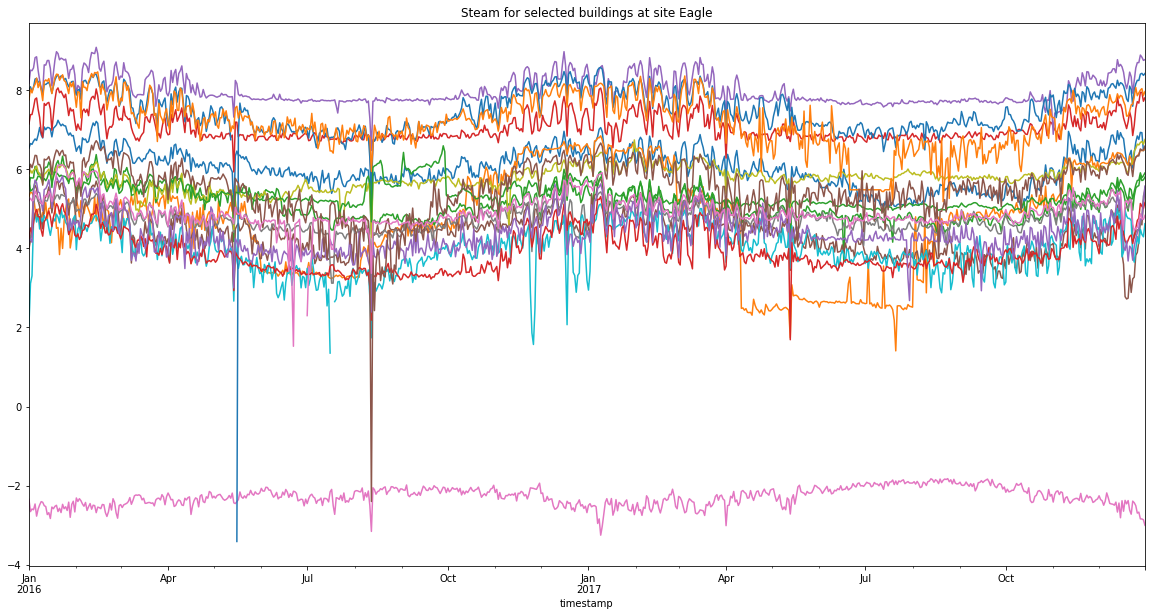

Site Eagle has good steam data from 17 buildings:
 ['Eagle_health_Athena', 'Eagle_assembly_Herbert', 'Eagle_public_Alvin', 'Eagle_education_Roman', 'Eagle_education_Peter', 'Eagle_lodging_Dawn', 'Eagle_education_Wesley', 'Eagle_health_Vincenza', 'Eagle_office_Francis', 'Eagle_office_Sheree', 'Eagle_education_Sherrill', 'Eagle_education_Brooke', 'Eagle_education_Will', 'Eagle_education_Petra', 'Eagle_lodging_Trina', 'Eagle_health_Reuben', 'Eagle_education_Teresa']


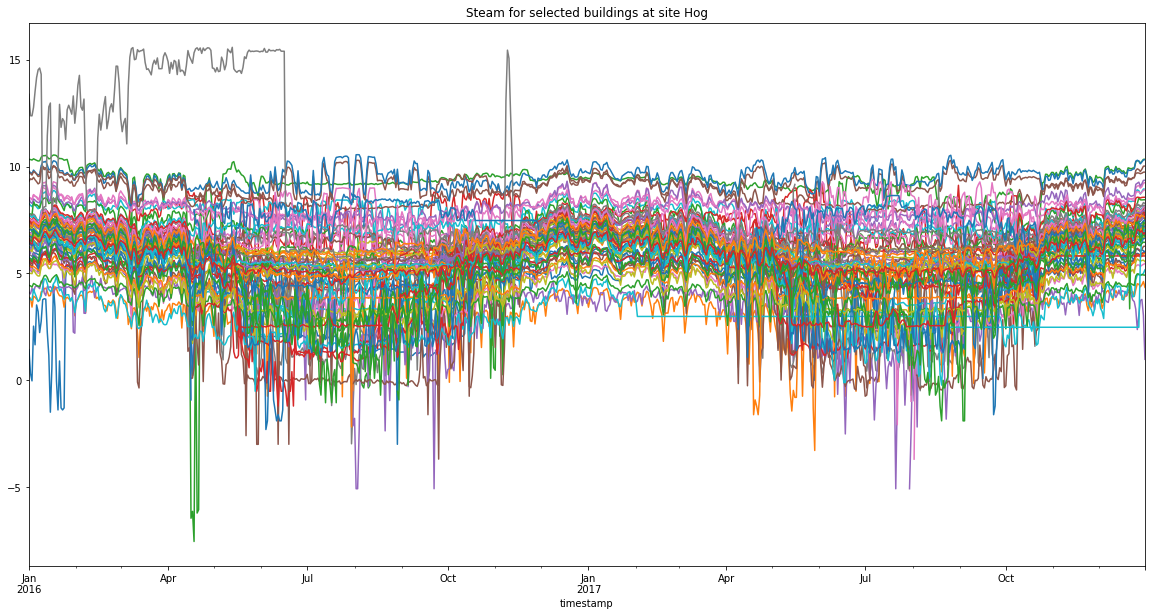

Site Hog has good steam data from 64 buildings:
 ['Hog_other_Noma', 'Hog_education_Wayne', 'Hog_services_Adrianna', 'Hog_lodging_Shanti', 'Hog_education_Jordan', 'Hog_office_Cornell', 'Hog_education_Martha', 'Hog_office_Sonny', 'Hog_office_Elizbeth', 'Hog_office_Candi', 'Hog_office_Corey', 'Hog_office_Cordelia', 'Hog_public_Kevin', 'Hog_office_Jillian', 'Hog_office_Terry', 'Hog_office_Shawna', 'Hog_education_Janell', 'Hog_lodging_Mauricio', 'Hog_health_Kesha', 'Hog_food_Morgan', 'Hog_office_Nia', 'Hog_office_Joey', 'Hog_assembly_Colette', 'Hog_industrial_Willette', 'Hog_services_Danny', 'Hog_office_Bessie', 'Hog_office_Catharine', 'Hog_office_Gustavo', 'Hog_office_Rolando', 'Hog_office_Bill', 'Hog_office_Man', 'Hog_office_Charla', 'Hog_office_Betsy', 'Hog_lodging_Ora', 'Hog_office_Elnora', 'Hog_education_Luvenia', 'Hog_parking_Bernardo', 'Hog_office_Leanne', 'Hog_office_Josefina', 'Hog_education_Jared', 'Hog_lodging_Nikki', 'Hog_office_Ervin', 'Hog_office_Catalina', 'Hog_lodging_Celest

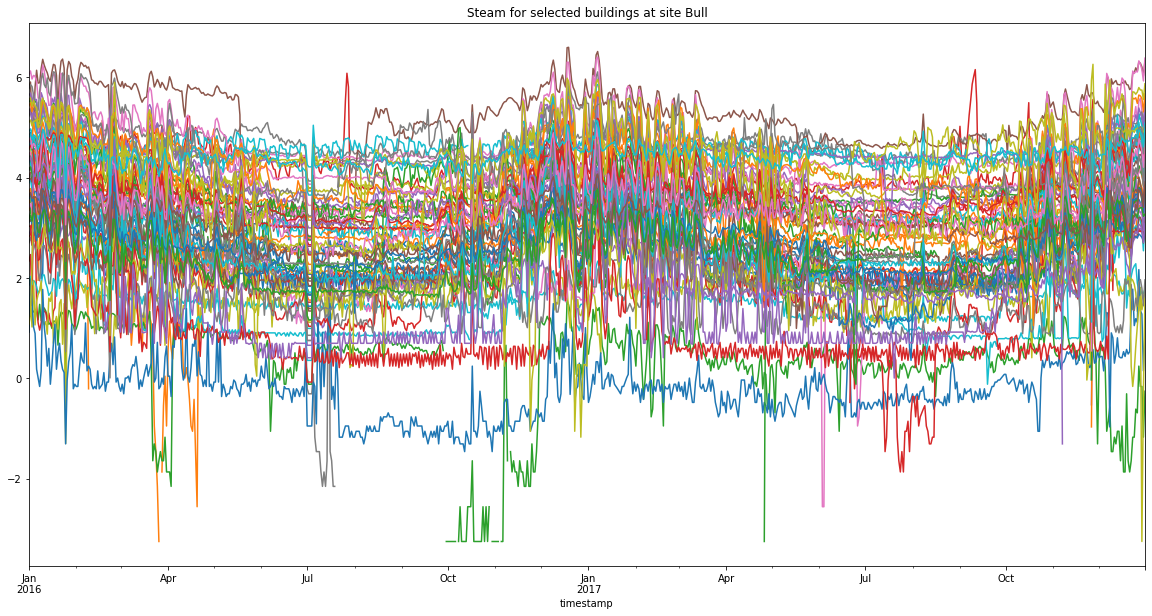

Site Bull has good steam data from 60 buildings:
 ['Bull_education_Magaret', 'Bull_office_Myron', 'Bull_education_Myra', 'Bull_education_Dan', 'Bull_lodging_Melissa', 'Bull_lodging_Caren', 'Bull_education_Kristal', 'Bull_assembly_Amalia', 'Bull_education_Arthur', 'Bull_assembly_Lesa', 'Bull_education_Roland', 'Bull_education_Joseph', 'Bull_education_Miquel', 'Bull_office_Efren', 'Bull_lodging_Lettie', 'Bull_lodging_Travis', 'Bull_public_Jefferson', 'Bull_education_Barry', 'Bull_lodging_Leonard', 'Bull_education_Dania', 'Bull_education_Reynaldo', 'Bull_education_Reina', 'Bull_assembly_Freddie', 'Bull_education_Genie', 'Bull_education_Tracey', 'Bull_education_Mario', 'Bull_education_Linnie', 'Bull_assembly_Dorethea', 'Bull_education_Miranda', 'Bull_education_Roseann', 'Bull_lodging_Carie', 'Bull_education_Krista', 'Bull_assembly_Gerri', 'Bull_education_Lyn', 'Bull_office_Rob', 'Bull_education_Dora', 'Bull_education_Jae', 'Bull_education_Hayley', 'Bull_education_Pablo', 'Bull_education_Pa

In [7]:
# Plot temperature time series for one column (building). 
cols=stm_df.columns
uniq_sites = [x for x in set(all_sites)]
show_legend = False
for site in uniq_sites:
    suitable_bldgs=[]
    for bldg in cols:
        if bldg.startswith(site):  # and 'education' in bldg and bldg.endswith('ll'):
            temp_df = stm_df[bldg]
            smooth = temp_df.resample("1D").mean()  
            count_nan=np.isnan(smooth).sum()
            count_zero=smooth.isin([0]).sum()
            if count_nan<=0 and count_zero<=5:
                suitable_bldgs.append(bldg)
                np.seterr(divide = 'ignore') 
                logs = np.log(smooth)
                logs.plot(figsize=(20,10))
                np.seterr(divide = 'warn') 
    num_bldg = len(suitable_bldgs)
    if num_bldg>0:
        plt.title("Steam for selected buildings at site "+site)
        if show_legend:
            plt.legend()
        plt.show()
        print("Site",site,"has good steam data from",num_bldg,"buildings:\n",suitable_bldgs)
